Script adapted from GPT-5, before I ran the experiment, intented to process the simulated data

[1.75       1.75087432 1.75174858 ... 1.76124718 1.76138313 1.76151851] [3.08452228 3.08976874 3.08816016 ... 3.28723795 3.28230251 3.28749273]
Applying high-pass filter: cutoff=0.001 Hz, fs=1000 Hz, order=3
Applying high-pass filter: cutoff=0.001 Hz, fs=1000 Hz, order=3
[0.94732044 0.94819476 0.94906902 ... 0.08022909 0.08036495 0.08050022] [1.65993051 1.66517692 1.66356828 ... 0.16827821 0.16334276 0.16853298]
200000 1000 200
Window size: 200000 samples (200 seconds)
range(0, 1800000, 100000)
0
100000
200000
300000
400000
500000
600000
700000
800000
900000
1000000
1100000
1200000
1300000
1400000
1500000
1600000
1700000


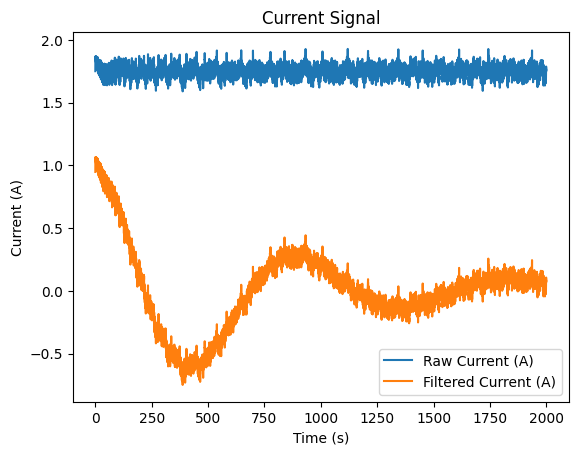

In [81]:
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq
# for debugging mainly
import matplotlib.pyplot as plt

# ----------------------------
# User parameters
# ----------------------------
cell_capacity_Ah = 3.5       # Ah
window_size_s = 200          # seconds
fs = 1000                    # Hz (sampling frequency)
f_pass = 1e-3                # Hz (high-pass filter cutoff)
frequencies = np.logspace(np.log10(0.01), np.log10(2), 30)  # injected f_n
hp_order = 3                 # high-pass filter order

# ----------------------------
# Load BaSyTec CSV
# ----------------------------
# CSV must have columns: 'time_s', 'current_A', 'voltage_V'
df = pd.read_csv("simulated_CCSM_log_small.csv")
t = df['time_s'].to_numpy()
I_raw = df['current_A'].to_numpy()
U_raw = df['voltage_V'].to_numpy()

# DEBUG: Print raw data shapes
print(I_raw, U_raw)
# ----------------------------
# High-pass filter
# ----------------------------
def highpass_filter(data, cutoff, fs, order=3):
    print(f"Applying high-pass filter: cutoff={cutoff} Hz, fs={fs} Hz, order={order}")
    '''
        data: 1D numpy array of raw data
        cutoff: cutoff frequency in Hz
        fs: sampling frequency in Hz
        order: filter order
        Returns: filtered data as a 1D numpy array
    '''
    nyq = 0.5 * fs # nyq = 500
    norm_cutoff = cutoff / nyq 
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)
I_hp = highpass_filter(I_raw, f_pass, fs, hp_order)
U_hp = highpass_filter(U_raw, f_pass, fs, hp_order)

# DEBUG: Print filtered data shapes
print(I_hp, U_hp)

# ----------------------------
# Sliding window DFT
# ----------------------------
# Calculate window size in samples
N_win = int(window_size_s * fs)  # N_win is the number of samples in the window
print(N_win, fs, window_size_s) 
half_win = N_win // 2 # half_win is used to find the center of the window
win_func = hann(N_win)
print(f"Window size: {N_win} samples ({window_size_s} seconds)")


plt.plot(t, I_raw, label='Raw Current (A)')
plt.plot(t, I_hp, label='Filtered Current (A)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Current Signal')



results_Q = []
results_ReZtr = []

# Integrate current to get charged capacity Q
Q_cumulative = np.cumsum(I_raw) / fs / 3600  # in Ah

print(range(0, len(t) - N_win, int(N_win/2)))


for start_idx in range(0, len(t) - N_win, int(N_win/2)):
    print(start_idx)
    idx = slice(start_idx, start_idx + N_win)
    I_win = I_hp[idx] * win_func
    U_win = U_hp[idx] * win_func

    # FFT
    I_fft = fft(I_win)
    U_fft = fft(U_win)
    freqs = fftfreq(N_win, 1/fs)

    # Keep only positive frequencies
    mask_pos = freqs > 0
    freqs = freqs[mask_pos]
    I_fft = I_fft[mask_pos]
    U_fft = U_fft[mask_pos]

    # Compute impedance at injected frequencies
    Z_f = []
    for f_target in frequencies:
        idx_f = np.argmin(np.abs(freqs - f_target))
        Z_val = U_fft[idx_f] / I_fft[idx_f]
        Z_f.append((freqs[idx_f], Z_val))

    # Find transition frequency = min(Im(Z))
    f_vals = np.array([f for f, Z in Z_f])
    Z_vals = np.array([Z for f, Z in Z_f])
    imag_parts = np.imag(Z_vals)
    f_tr_idx = np.argmin(imag_parts)
    Re_Ztr = np.real(Z_vals[f_tr_idx])

    # Capacity at window center
    Q_mid = Q_cumulative[start_idx + half_win]

    results_Q.append(Q_mid)
    results_ReZtr.append(Re_Ztr)

results_Q = np.array(results_Q)
results_ReZtr = np.array(results_ReZtr)

# print(results_Q)
# print(results_ReZtr)

# ----------------------------
# Plating onset detection
# ----------------------------
# d1 = np.gradient(results_ReZtr, results_Q)
# d2 = np.gradient(d1, results_Q)

# if results_ReZtr[0] < results_ReZtr[-1]:
#     onset_idx = np.argmax(d1)  # increasing baseline → first derivative peak
# else:
#     onset_idx = np.argmax(d2)  # decreasing baseline → second derivative peak

# onset_Q = results_Q[onset_idx]
# onset_ReZtr = results_ReZtr[onset_idx]

# print(f"Plating onset detected at Q = {onset_Q:.4f} Ah, Re(Z_tr) = {onset_ReZtr:.4f} Ω")

# # Optional: save results for plotting
# pd.DataFrame({
#     "Q_Ah": results_Q,
#     "Re_Ztr_ohm": results_ReZtr
# }).to_csv("re_Ztr_vs_Q.csv", index=False)


I_raw shape: (2000000,), U_raw shape: (2000000,), total_samples_len: 2000000000
[1.75       1.75087432 1.75174858 ... 1.76124718 1.76138313 1.76151851] [3.08452228 3.08976874 3.08816016 ... 3.28723795 3.28230251 3.28749273]
200000 1000 200
Window size: 200000 samples (200 seconds)
I_hp: (2000000,), U_hp: (2000000,), win_func: (200000,)
total_samples_len: [0.000000e+00 1.000000e-03 2.000000e-03 ... 1.999997e+03 1.999998e+03
 1.999999e+03], N_win: 200000
range(0, 1600000, 200000)
temp: 8
start_idx: 0, N_win: 200000, t: [0.000000e+00 1.000000e-03 2.000000e-03 ... 1.999997e+03 1.999998e+03
 1.999999e+03]
Processing window: range(0, 200000)
200000 200000


IndexError: index 8 is out of bounds for axis 0 with size 8

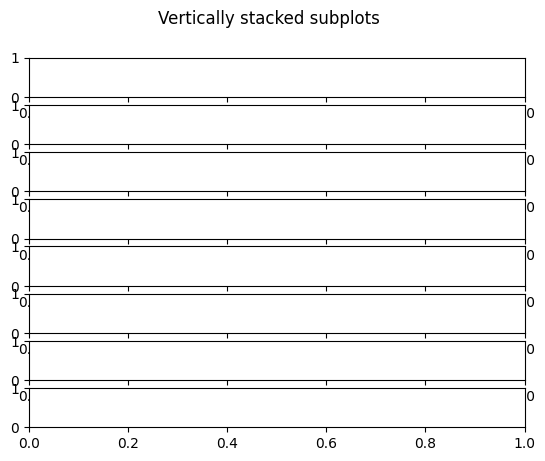

In [105]:
## skipping filter again
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq
# for debugging mainly
import matplotlib.pyplot as plt

# ----------------------------
# User parameters
# ----------------------------
cell_capacity_Ah = 3.5       # Ah
window_size_s = 200          # seconds
fs = 1000                    # Hz (sampling frequency)
f_pass = 1e-3                # Hz (high-pass filter cutoff)
frequencies = np.logspace(np.log10(0.01), np.log10(2), 30)  # injected f_n
hp_order = 3                 # high-pass filter order

# ----------------------------
# Load BaSyTec CSV
# ----------------------------
# CSV must have columns: 'time_s', 'current_A', 'voltage_V'
df = pd.read_csv("simulated_CCSM_log_small.csv")
t = df['time_s'].to_numpy()
I_raw = df['current_A'].to_numpy()
U_raw = df['voltage_V'].to_numpy()

# DEBUG: Print raw data shapes
print(f"I_raw shape: {I_raw.shape}, U_raw shape: {U_raw.shape}, total_samples_len: {total_samples_len}")
# ----------------------------
# High-pass filter
# ----------------------------
def highpass_filter(data, cutoff, fs, order=3):
    print(f"Applying high-pass filter: cutoff={cutoff} Hz, fs={fs} Hz, order={order}")
    '''
        data: 1D numpy array of raw data
        cutoff: cutoff frequency in Hz
        fs: sampling frequency in Hz
        order: filter order
        Returns: filtered data as a 1D numpy array
    '''
    nyq = 0.5 * fs # nyq = 500
    norm_cutoff = cutoff / nyq 
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)
# I_hp = highpass_filter(I_raw, f_pass, fs, hp_order)
# U_hp = highpass_filter(U_raw, f_pass, fs, hp_order)

I_hp = I_raw
U_hp = U_raw

# DEBUG: Print filtered data shapes
print(I_hp, U_hp)

# ----------------------------
# Sliding window DFT
# ----------------------------
# Calculate window size in samples
N_win = int(window_size_s * fs)  # N_win is the number of samples in the window
print(N_win, fs, window_size_s) 
half_win = N_win // 2 # half_win is used to find the center of the window
win_func = hann(N_win)
print(f"Window size: {N_win} samples ({window_size_s} seconds)")


# plt.plot(t, I_raw, label='Raw Current (A)')
# plt.plot(t, I_hp, label='Filtered Current (A)')
# plt.legend()
# plt.xlabel('Time (s)')
# plt.ylabel('Current (A)')
# plt.title('Current Signal')



results_Q = []
results_ReZtr = []

# Integrate current to get charged capacity Q
Q_cumulative = np.cumsum(I_raw) / fs / 3600  # in Ah

print(f"I_hp: {I_hp.shape}, U_hp: {U_hp.shape}, win_func: {win_func.shape}")

# index is the start index of the current window
print(f"total_samples_len: {t}, N_win: {N_win}")
sample_index = range(0, len(t) - N_win * 2, N_win)
print(sample_index)
for start_idx in sample_index:
    # create len(sample_index) number of subplots
    temp = len(sample_index)
    print(f"temp: {temp}")
    fig, axs = plt.subplots(temp)
    fig.suptitle('Vertically stacked subplots')

    print(f"start_idx: {start_idx}, N_win: {N_win}, t: {t}")
    idx = range(start_idx, start_idx + N_win)
    print(f"Processing window: {idx}")
    print(len(I_hp[idx]), len(win_func)) ###########################################################
    I_win = I_hp[idx] * win_func
    U_win = U_hp[idx] * win_func

    # FFT
    I_fft = fft(I_win)
    U_fft = fft(U_win)
    freqs = fftfreq(N_win, 1/fs)

    # Keep only positive frequencies
    mask_pos = freqs > 0
    freqs = freqs[mask_pos]
    I_fft = I_fft[mask_pos]
    U_fft = U_fft[mask_pos]

    axs[temp].plot(freqs, np.abs(I_fft), label=f'FFT Current, index: {temp}')

    # Compute impedance at injected frequencies
    Z_f = []
    for f_target in frequencies:
        idx_f = np.argmin(np.abs(freqs - f_target))
        Z_val = U_fft[idx_f] / I_fft[idx_f]
        Z_f.append((freqs[idx_f], Z_val))

    # Find transition frequency = min(Im(Z))
    f_vals = np.array([f for f, Z in Z_f])
    Z_vals = np.array([Z for f, Z in Z_f])
    imag_parts = np.imag(Z_vals)
    f_tr_idx = np.argmin(imag_parts)
    Re_Ztr = np.real(Z_vals[f_tr_idx])

    # Capacity at window center
    Q_mid = Q_cumulative[start_idx + half_win]

    results_Q.append(Q_mid)
    results_ReZtr.append(Re_Ztr)

results_Q = np.array(results_Q)
results_ReZtr = np.array(results_ReZtr)

print(results_Q)
print(results_ReZtr)

# ----------------------------
# Plating onset detection
# ----------------------------
d1 = np.gradient(results_ReZtr, results_Q)
d2 = np.gradient(d1, results_Q)

if results_ReZtr[0] < results_ReZtr[-1]:
    onset_idx = np.argmax(d1)  # increasing baseline → first derivative peak
else:
    onset_idx = np.argmax(d2)  # decreasing baseline → second derivative peak

onset_Q = results_Q[onset_idx]
onset_ReZtr = results_ReZtr[onset_idx]

print(f"Plating onset detected at Q = {onset_Q:.4f} Ah, Re(Z_tr) = {onset_ReZtr:.4f} Ω")

# Optional: save results for plotting
pd.DataFrame({
    "Q_Ah": results_Q,
    "Re_Ztr_ohm": results_ReZtr
}).to_csv("re_Ztr_vs_Q.csv", index=False)


[1.75       1.75873411 1.76741352 ... 1.77211321 1.77157984 1.7709589 ] [3.08730605 3.0879795  3.08909987 ... 3.10929838 3.10662669 3.10849803]
[1.75       1.75873411 1.76741352 ... 1.77211321 1.77157984 1.7709589 ] [3.08730605 3.0879795  3.08909987 ... 3.10929838 3.10662669 3.10849803]
200000 1000 200
Window size: 200000 samples (200 seconds)
size: 20000


c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
c:\Users\user\AppData\Local\Programs\Python\Python312\Lib\site-packages\matplotlib\cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


(-100.0, 100.0)

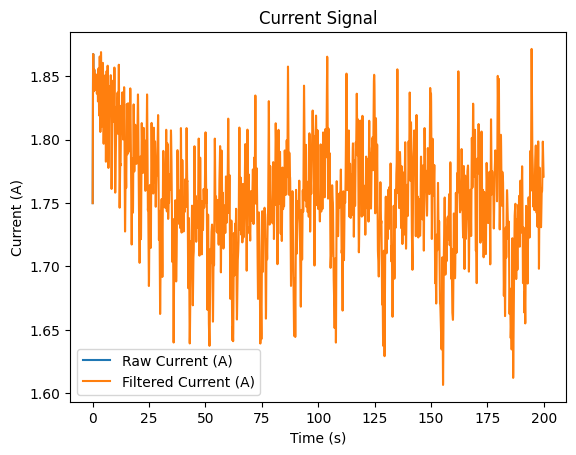

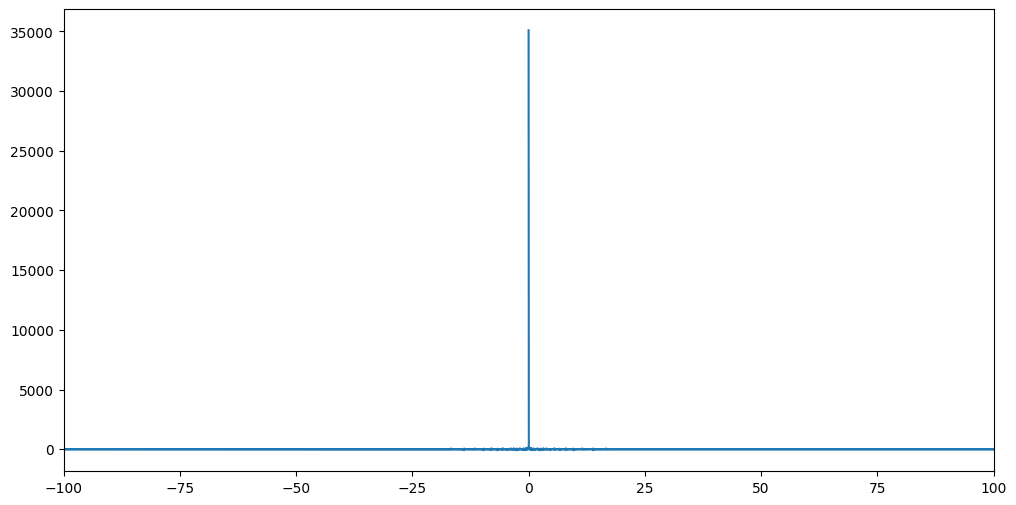

In [ ]:
### trying to skip highpass filter
import numpy as np
import pandas as pd
from scipy.signal import butter, filtfilt
from scipy.signal.windows import hann
from scipy.fft import fft, fftfreq
# for debugging mainly
import matplotlib.pyplot as plt

# ----------------------------
# User parameters
# ----------------------------
cell_capacity_Ah = 3.5       # Ah
window_size_s = 200          # seconds
fs = 1000                    # Hz (sampling frequency)
f_pass = 1e-3                # Hz (high-pass filter cutoff)
frequencies = np.logspace(np.log10(0.01), np.log10(2), 30)  # injected f_n
hp_order = 3                 # high-pass filter order

# ----------------------------
# Load BaSyTec CSV
# ----------------------------
# CSV must have columns: 'time_s', 'current_A', 'voltage_V'
df = pd.read_csv("simulated_CCSM_log_small.csv")
t = df['time_s'].to_numpy()
I_raw = df['current_A'].to_numpy()
U_raw = df['voltage_V'].to_numpy()

# DEBUG: Print raw data shapes
print(I_raw, U_raw)
# ----------------------------
# High-pass filter
# ----------------------------
def highpass_filter(data, cutoff, fs, order=3):
    print(f"Applying high-pass filter: cutoff={cutoff} Hz, fs={fs} Hz, order={order}")
    '''
        data: 1D numpy array of raw data
        cutoff: cutoff frequency in Hz
        fs: sampling frequency in Hz
        order: filter order
        Returns: filtered data as a 1D numpy array
    '''
    nyq = 0.5 * fs # nyq = 500
    norm_cutoff = cutoff / nyq 
    b, a = butter(order, norm_cutoff, btype='high', analog=False)
    return filtfilt(b, a, data)
# I_hp = highpass_filter(I_raw, f_pass, fs, hp_order)
# U_hp = highpass_filter(U_raw, f_pass, fs, hp_order)

I_hp = I_raw  # Skipping high-pass filter for testing
U_hp = U_raw  # Skipping high-pass filter for testing

# DEBUG: Print filtered data shapes
print(I_hp, U_hp)

# ----------------------------
# Sliding window DFT
# ----------------------------
# Calculate window size in samples
N_win = int(window_size_s * fs)  # N_win is the number of samples in the window
print(N_win, fs, window_size_s) 
half_win = N_win // 2 # half_win is used to find the center of the window
win_func = hann(N_win)
print(f"Window size: {N_win} samples ({window_size_s} seconds)")


plt.plot(t[0:100], I_raw[0:100], label='Raw Current (A)')
plt.plot(t, I_hp, label='Filtered Current (A)')
plt.legend()
plt.xlabel('Time (s)')
plt.ylabel('Current (A)')
plt.title('Current Signal')



I_f = np.fft.fft(I_hp) # FFT of the high-pass filtered current signal
U_f = np.fft.fft(U_hp) # FFT of the high-pass filtered voltage signal
print("size:", n)
f = np.fft.fftfreq(n, d=1/fs)
plt.figure(figsize=(12, 6))
plt.plot(f, I_f, label='FFT Current (A)')
plt.xlim(-100, 100)  # Limit x-axis to positive frequencies





In [ ]:
# print(range(0, len(t) - N_win, int(N_win/2)))
print(N_win)
print(f"length of t: {len(t)}")

200000
length of t: 20000
